#Após a instalação destes pacotes, é necessário reinicializar o kernel do COLAB

In [6]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.8 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.6 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Imports

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cv2 as cv
import shutil

# Questão 1

Escolha uma das metodologias que você implementou na segunda
lista para gerar correspondências entre um par de imagens. Aplique-a em
5 pares de imagens para calcular suas homografias, e aplique-as para gerar
panoramas entre os pares de imagens (um panorama por par).
Dica: use a função warpPerspective da OpenCV.

In [2]:
# !gdown -q 1-60S9g4WwkS7rLXoIMGUQq61DRH9d08a
!mkdir -p /content/images/q1
!gdown -q 1hKa_5-jQn9zJt0nfACP4vlO5PeTteGT6
!unzip -q /content/images.zip -d /content/images/q1
!rm -f /content/images.zip

replace /content/images/q1/a1/img1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
def select_panorama_area(result):

  row_limit_inf = 10000
  row_limit_sup = 0

  col_limit_inf = 10000
  col_limit_sup = 0

  for i in range(result.shape[0]):
    if (result[i, :] != 0).any():
      row_limit_inf = min(row_limit_inf, i)
      row_limit_sup = max(row_limit_sup, i)

  for i in range(result.shape[1]):
    if (result[:, i] != 0).any():
      col_limit_inf = min(col_limit_inf, i)
      col_limit_sup = max(col_limit_sup, i)

  return result[row_limit_inf:row_limit_sup-2, col_limit_inf:col_limit_sup-2].copy()

In [4]:
# Methodology :

# 1 - SIFT to get Key Points and features
# 2 - BFMatcher to make points matching


def KeyPointsAndFeatures(image):

    sift = cv.xfeatures2d.SIFT_create()
    imageGray = cv.cvtColor(image.copy(), cv.COLOR_RGB2GRAY)
    key_points, features = sift.detectAndCompute(imageGray, None)

    return key_points, features

def MatchKeyPointsBF(features1, features2):

    matcher = cv.BFMatcher(cv.NORM_L2, crossCheck  = True)
    best_matches = matcher.match(features1, features2)
    ordened_best_matches = sorted(best_matches, key = lambda x:x.distance)

    return ordened_best_matches

def ComputeHomography(key_points1, key_points2, features1, features2, matches):

    keyPointsA = np.float32([kp.pt for kp in key_points1])
    keyPointsB = np.float32([kp.pt for kp in key_points2])

    pointsA = np.float32([keyPointsA[m.queryIdx] for m in matches])
    pointsB = np.float32([keyPointsB[m.trainIdx] for m in matches])

    (H, status) = cv.findHomography(pointsA, pointsB, cv.RANSAC, 5.0)
    return H

def get_matches(image1, image2):

    KeyPoints1, features1 = KeyPointsAndFeatures(image1)
    KeyPoints2, features2 = KeyPointsAndFeatures(image2)
    matches = MatchKeyPointsBF(features1, features2)
    return KeyPoints1, KeyPoints2, features1, features2, matches

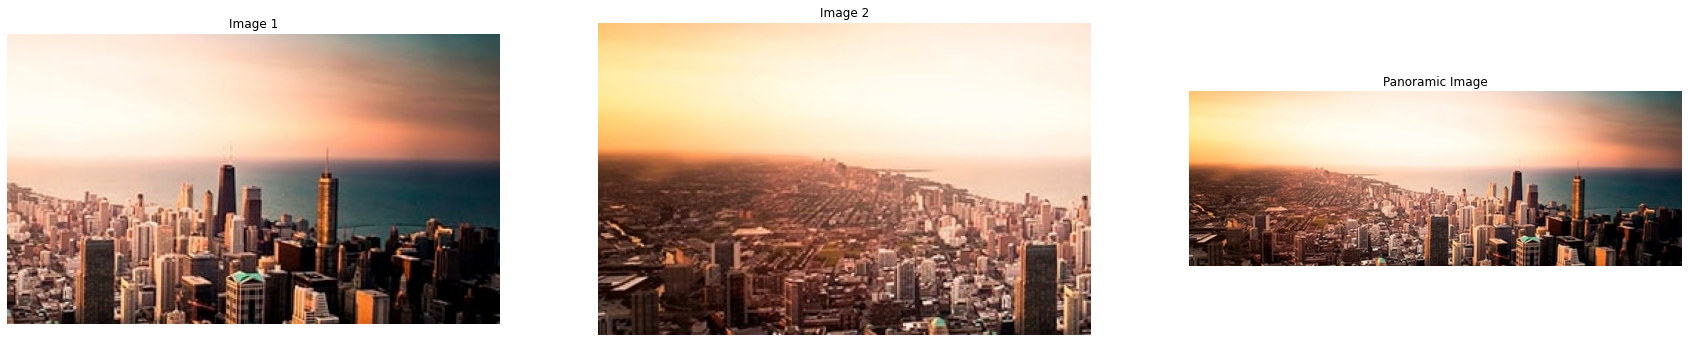

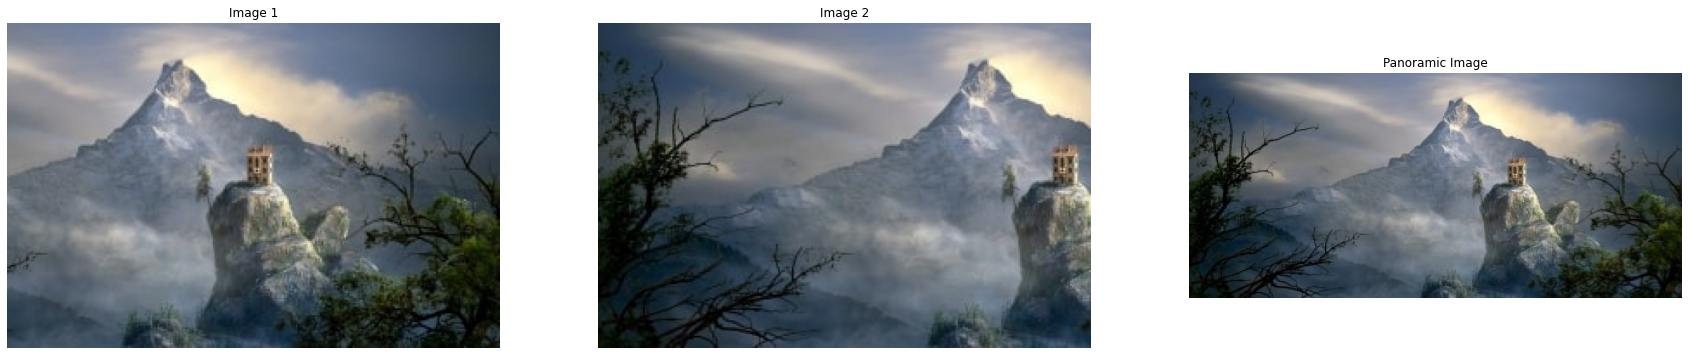

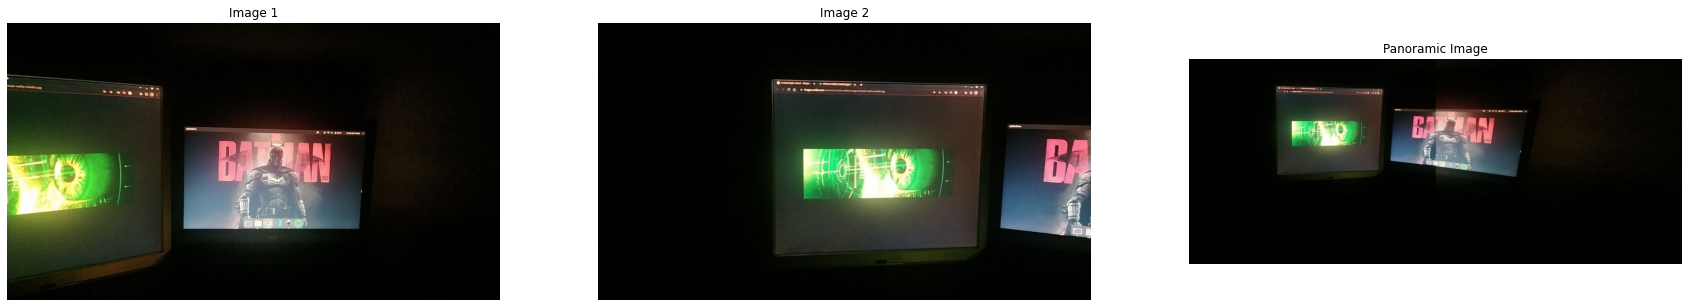

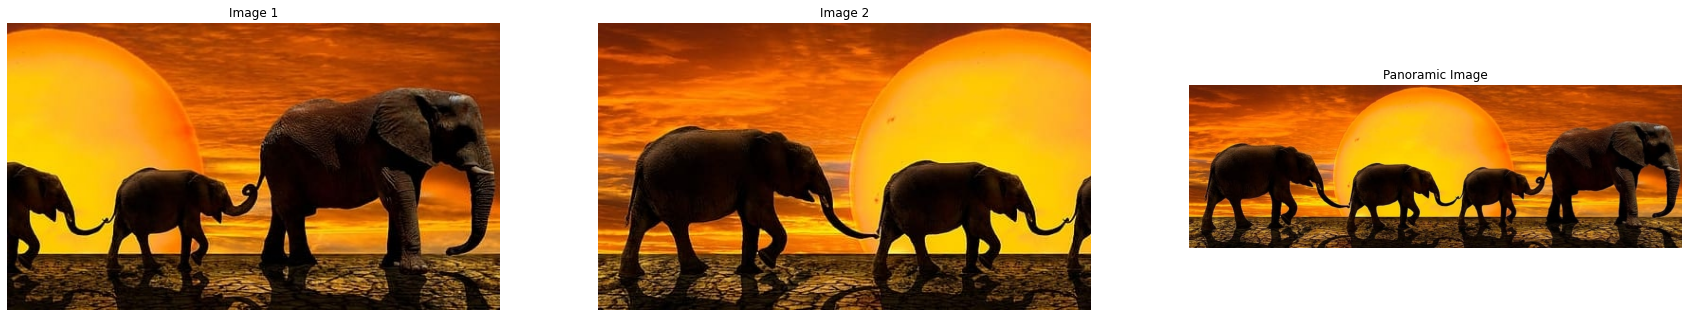

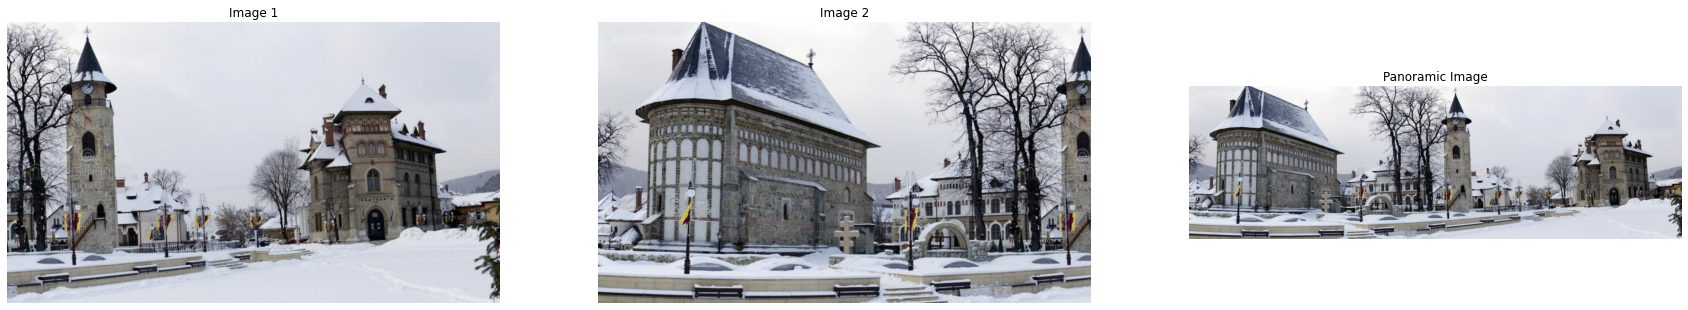

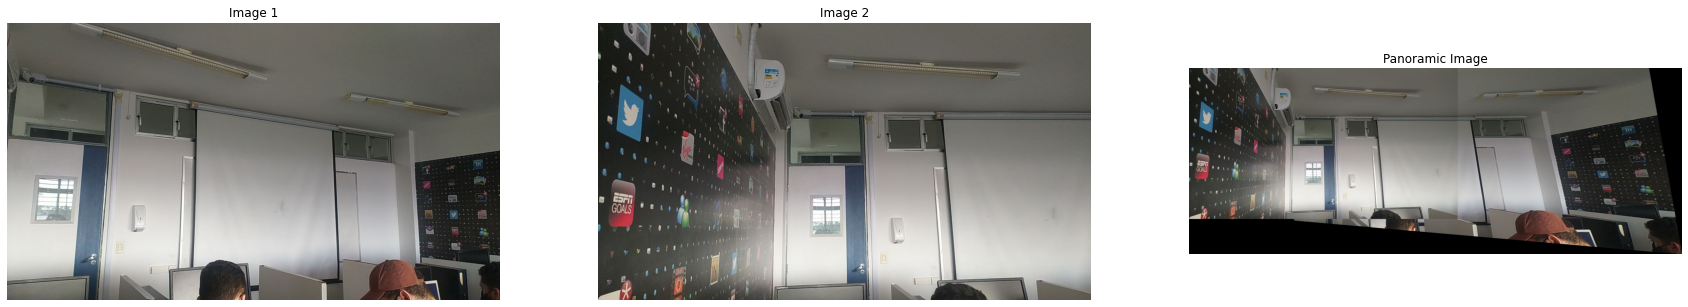

In [5]:
for index, srcPath in enumerate(glob("/content/images/q1/*")):
  for path1 in glob(f"{srcPath}/*2.jpg"):

    path2 = path1.replace("2.jpg", "1.jpg")

    image1 = cv.cvtColor(cv.imread(path1), cv.COLOR_BGR2RGB)
    image2 = cv.cvtColor(cv.imread(path2), cv.COLOR_BGR2RGB)

    KeyPoints1, KeyPoints2, features1, features2, matches = get_matches(image1, image2)
    H = ComputeHomography(KeyPoints1, KeyPoints2, features1, features2, matches)
    
    width = int(image1.shape[1] + image2.shape[1])
    height = int(image1.shape[0] + image2.shape[0])

    result = cv.warpPerspective(image1, H, (width, height))
    result[0:image2.shape[0], 0:image2.shape[1]] = image2

    plt.figure(figsize=(30,25))

    plt.subplot(131)
    plt.imshow(image1)
    plt.title("Image 1")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(image2)
    plt.title("Image 2")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(select_panorama_area(result))
    plt.title("Panoramic Image")
    plt.axis('off')

# Questão 2

Repita a questão anterior com 5 trios de imagens, alinhando as
imagens no plano da primeira imagem. Repita o mesmo alinhando no plano
da segunda imagem, e da terceira imagem. Note que aqui ser ́a necessário
compor as transformações de homografia em alguns casos, ou calcular inversas.

In [6]:
!mkdir -p /content/images/q2
!gdown -q 1v39nSSTHmV_7MmMvTjzGlQOEa3DAPdpg
!unzip -q /content/images2.zip -d /content/images/q2
!rm -f /content/images2.zip

In [7]:
def concat_images(image1, image2, H):

  width = int(image1.shape[1] + image2.shape[1])
  height = int(image1.shape[0] + image2.shape[0])

  result = cv.warpPerspective(image2, H, (width, height))
  result[0:image2.shape[0], 0:image2.shape[1]] = image1

  return result


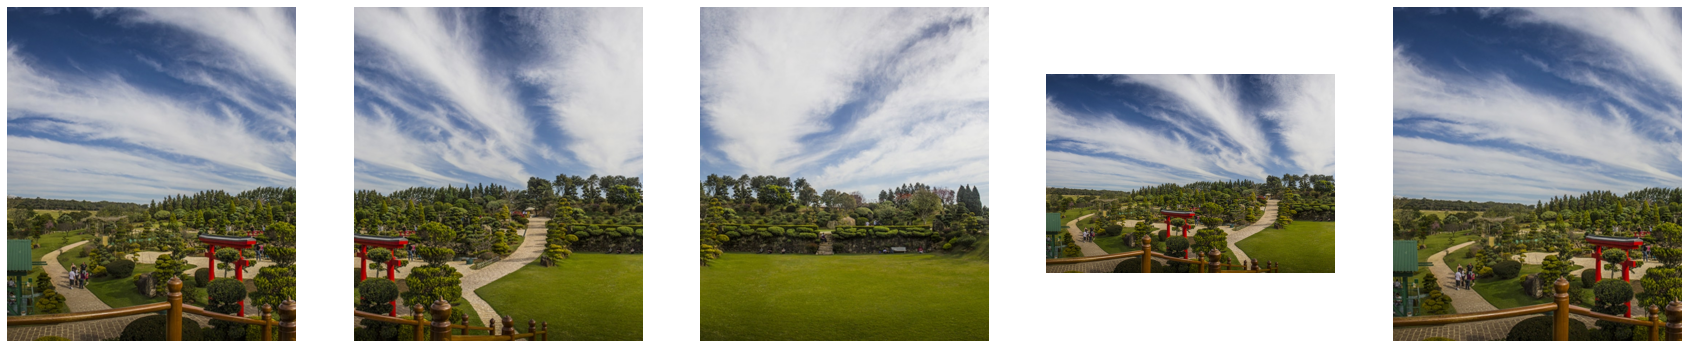

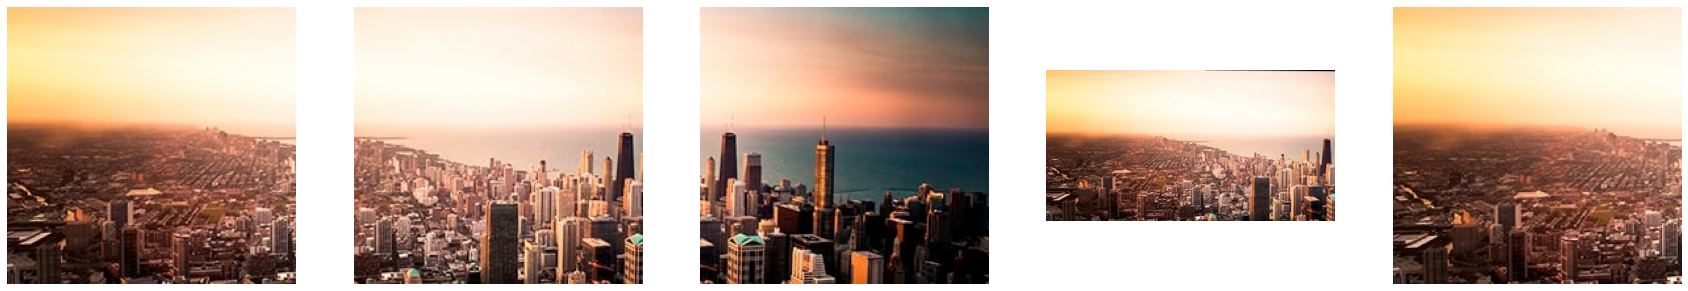

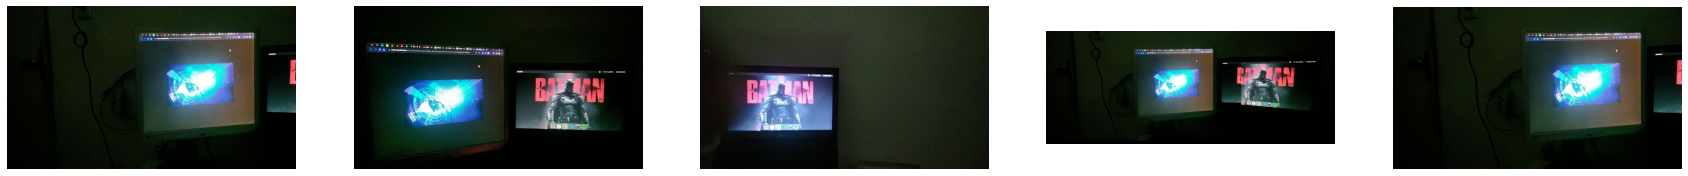

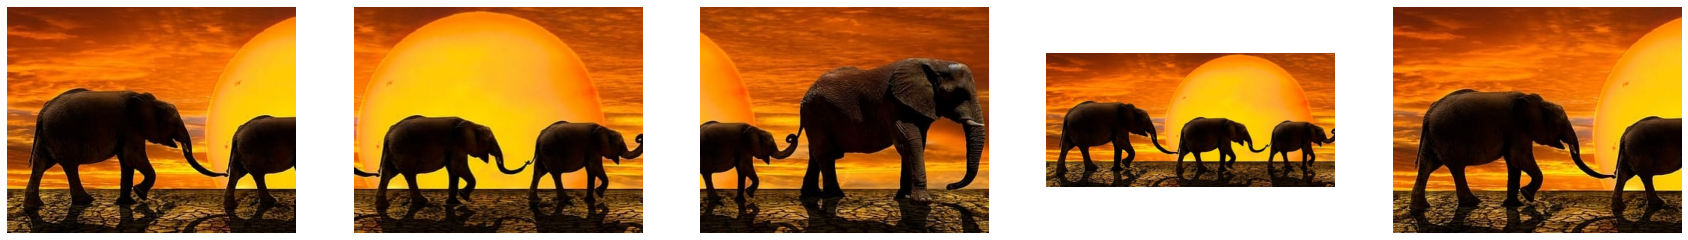

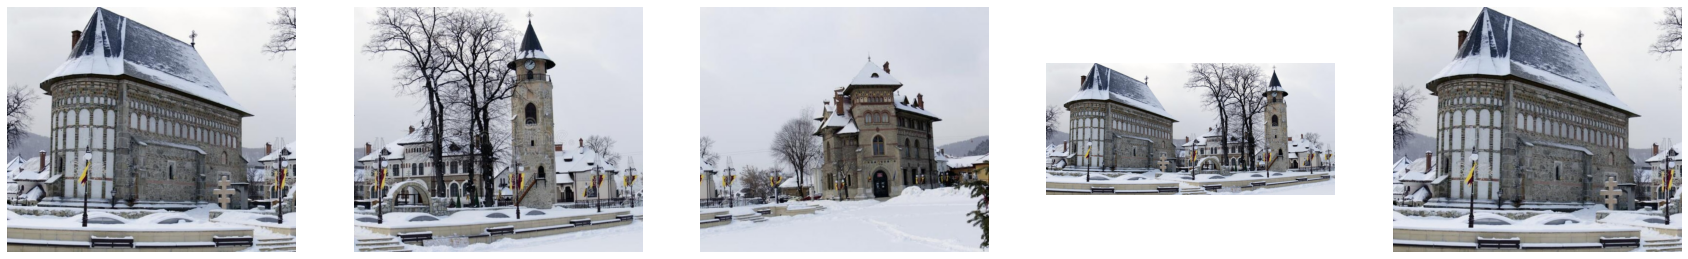

In [16]:
'''
FALTOU IMPLEMENTAR A CRIAÇÃO DE PANORAMA PARA OS PLANOS DAS IMAGENS 1 E 3

'''


for path_img1 in glob("/content/images/q2/**/*1.jpg"):

  path_img2 = path_img1.replace("1.jpg", "2.jpg")
  path_img3 = path_img1.replace("1.jpg", "3.jpg")

  H, W = image1.shape[:2]

  image1 = cv.cvtColor(cv.imread(path_img1), cv.COLOR_BGR2RGB)
  image2 = cv.cvtColor(cv.imread(path_img2), cv.COLOR_BGR2RGB)
  image3 = cv.cvtColor(cv.imread(path_img3), cv.COLOR_BGR2RGB)
  
  plt.figure(figsize = (30, 20))
  plt.subplot(151)
  plt.imshow(image1)
  plt.axis('off')

  plt.subplot(152)
  plt.imshow(image2)
  plt.axis('off')

  plt.subplot(153)
  plt.imshow(image3)
  plt.axis('off')

  plt.subplot(154)

  KeyPoints1, KeyPoints2, features1, features2, matches = get_matches(image2, image1)
  H12 = ComputeHomography(KeyPoints1, KeyPoints2, features1, features2, matches)
  result12 = concat_images(image1, image2, H12)

  plt.imshow(select_panorama_area(result12))
  plt.axis('off')

  KeyPoints1x, KeyPoints2x, features1x, features2x, matchesx = get_matches(image3, image2)
  H23 = ComputeHomography(KeyPoints1x, KeyPoints2x, features1x, features2x, matchesx)
  result23 = concat_images(image1, image3, H12 * H23)

  plt.subplot(155)
  plt.imshow(select_panorama_area(result23))
  plt.axis('off')
  
  plt.show()